# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset **tanpa label** dengan ketentuan sebagai berikut:

1. **Sumber Dataset**: https://www.kaggle.com/datasets/wowevan/dataset-kesejahteraan-pekerja-indonesia?resource=download

   Dataset dapat diperoleh dari berbagai sumber, seperti public repositories (*Kaggle*, *UCI ML Repository*, *Open Data*) atau data primer yang Anda kumpulkan sendiri.
   
2. **Ketentuan Dataset**:
   - **Tanpa label**: Dataset tidak boleh memiliki label atau kelas.
   - **Jumlah Baris**: Minimal 1000 baris untuk memastikan dataset cukup besar untuk analisis yang bermakna.
   - **Tipe Data**: Harus mengandung data **kategorikal** dan **numerikal**.
     - *Kategorikal*: Misalnya jenis kelamin, kategori produk.
     - *Numerikal*: Misalnya usia, pendapatan, harga.

3. **Pembatasan**:  
   Dataset yang sudah digunakan dalam latihan clustering (seperti customer segmentation) tidak boleh digunakan.

# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [1147]:
!pip install category-encoders

In [1148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from category_encoders import BinaryEncoder
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.neighbors import NearestNeighbors

# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

In [1149]:
url_upah = "https://raw.githubusercontent.com/jasmeinalbr/Dicoding-ML-Permula-Submission/main/Dataset_inisiasi/rataRataUpah.csv"
url_min_upah = "https://raw.githubusercontent.com/jasmeinalbr/Dicoding-ML-Permula-Submission/main/Dataset_inisiasi/minUpah.csv"
url_kemiskinan = "https://raw.githubusercontent.com/jasmeinalbr/Dicoding-ML-Permula-Submission/main/Dataset_inisiasi/garisKemiskinan.csv"
url_pengeluaran = "https://raw.githubusercontent.com/jasmeinalbr/Dicoding-ML-Permula-Submission/main/Dataset_inisiasi/pengeluaran.csv"

In [1150]:
# Read file csv
df_upah = pd.read_csv(url_upah)
df_min_upah = pd.read_csv(url_min_upah)
df_kemiskinan = pd.read_csv(url_kemiskinan)
df_pengeluaran = pd.read_csv(url_pengeluaran)

In [1151]:
# Cek struktur dataset
df_upah.head()

,provinsi,tahun,upah
0,ACEH,2015,11226
1,ACEH,2016,13627
2,ACEH,2017,14809
3,ACEH,2018,13814
4,ACEH,2019,15065


In [1152]:
df_min_upah.head()

,provinsi,tahun,ump
0,ACEH,2002,330000.0
1,ACEH,2003,425000.0
2,ACEH,2004,550000.0
3,ACEH,2005,620000.0
4,ACEH,2006,820000.0


In [1153]:
df_kemiskinan.head()

,provinsi,jenis,daerah,tahun,periode,gk
0,ACEH,MAKANAN,PERKOTAAN,2015,MARET,293697.0
1,ACEH,MAKANAN,PERKOTAAN,2015,SEPTEMBER,302128.0
2,ACEH,MAKANAN,PERKOTAAN,2016,MARET,306243.0
3,ACEH,MAKANAN,PERKOTAAN,2016,SEPTEMBER,319768.0
4,ACEH,MAKANAN,PERDESAAN,2015,MARET,297479.0


In [1154]:
df_pengeluaran.head()

,provinsi,daerah,jenis,tahun,peng
0,ACEH,PERDESAAN,MAKANAN,2007,195176.0
1,ACEH,PERDESAAN,MAKANAN,2008,218781.0
2,ACEH,PERDESAAN,MAKANAN,2009,247427.0
3,ACEH,PERDESAAN,MAKANAN,2010,275749.0
4,ACEH,PERDESAAN,MAKANAN,2011,308000.0


In [1155]:
# Merge dataset rata-rata upah dan minimum upah berdasarkan 'provinsi' dan 'tahun'
df_upah_min_upah = df_upah.merge(df_min_upah, on=["provinsi", "tahun"], how="inner")

# Merge dataset garis kemiskinan dan pengeluaran berdasarkan 'provinsi', 'tahun', 'daerah', dan 'jenis'
df_kemiskinan_pengeluaran = df_kemiskinan.merge(df_pengeluaran, on=["provinsi", "tahun", "daerah", "jenis"], how="inner")

# Merge df_upah_min_upah dengan df_kemiskinan_pengeluaran berdasarkan 'provinsi' dan 'tahun'
df_kesejahteraan = df_upah_min_upah.merge(df_kemiskinan_pengeluaran, on=["provinsi", "tahun"], how="inner")

In [1156]:
# Cek data setelah merge
df_kesejahteraan.head()

,provinsi,tahun,upah,ump,jenis,daerah,periode,gk,peng
0,ACEH,2015,11226,1900000.0,MAKANAN,PERKOTAAN,MARET,293697.0,466355.0
1,ACEH,2015,11226,1900000.0,MAKANAN,PERKOTAAN,SEPTEMBER,302128.0,466355.0
2,ACEH,2015,11226,1900000.0,MAKANAN,PERDESAAN,MARET,297479.0,395136.0
3,ACEH,2015,11226,1900000.0,MAKANAN,PERDESAAN,SEPTEMBER,306737.0,395136.0
4,ACEH,2015,11226,1900000.0,MAKANAN,PERDESAANPERKOTAAN,MARET,296406.0,415354.0


# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset. EDA bertujuan untuk:

1. **Memahami Struktur Data**
   - Tinjau jumlah baris dan kolom dalam dataset.  
   - Tinjau jenis data di setiap kolom (numerikal atau kategorikal).

2. **Menangani Data yang Hilang**  
   - Identifikasi dan analisis data yang hilang (*missing values*). Tentukan langkah-langkah yang diperlukan untuk menangani data yang hilang, seperti pengisian atau penghapusan data tersebut.

3. **Analisis Distribusi dan Korelasi**  
   - Analisis distribusi variabel numerik dengan statistik deskriptif dan visualisasi seperti histogram atau boxplot.  
   - Periksa hubungan antara variabel menggunakan matriks korelasi atau scatter plot.

4. **Visualisasi Data**  
   - Buat visualisasi dasar seperti grafik distribusi dan diagram batang untuk variabel kategorikal.  
   - Gunakan heatmap atau pairplot untuk menganalisis korelasi antar variabel.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

### 1. Memahami Struktur Data

In [1157]:
# Cek jumlah baris dan kolom
print("Jumlah baris dan kolom:", df_kesejahteraan.shape)

Jumlah baris dan kolom: (5040, 9)


In [1158]:
# Cek tipe data setiap kolom
print("\nInfo dataset:")
print(df_kesejahteraan.info())


Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5040 entries, 0 to 5039
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   provinsi  5040 non-null   object 
 1   tahun     5040 non-null   int64  
 2   upah      5040 non-null   int64  
 3   ump       5040 non-null   float64
 4   jenis     5040 non-null   object 
 5   daerah    5040 non-null   object 
 6   periode   5040 non-null   object 
 7   gk        4992 non-null   float64
 8   peng      4992 non-null   float64
dtypes: float64(3), int64(2), object(4)
memory usage: 354.5+ KB
None


### 2. Menangani Data yang Hilang

In [1159]:
# Cek jumlah missing values di setiap kolom
print("\nMissing Values:")
print(df_kesejahteraan.isnull().sum())


Missing Values:
provinsi     0
tahun        0
upah         0
ump          0
jenis        0
daerah       0
periode      0
gk          48
peng        48
dtype: int64


Karena terdapat missing values pada kolom garis kemiskinan (gk) dan pengeluaran (peng) sebanyak 48 baris dari total 5.040 baris, langkah yang harus dilakukan :
Isi dengan Nilai Statistik (Mean/Median) karena nilai yang hilang tidak terlalu banyak dan bisa diestimasi. Keuntungannya tidak kehilangan data dan tetap mempertahankan jumlah sampel.

saya tidak menghapus missing value untuk mempertahankan jumlah data dan siapatau datanya masih berguna.

### 3. Analisis Distribusi dan Korelasi

In [1160]:
# Cek ringkasan statistik deskriptif untuk fitur numerik
numerical_features = ["upah", "ump", "gk", "peng"]

print("\nRingkasan statistik:")
print(df_kesejahteraan[numerical_features].describe())


Ringkasan statistik:
               upah           ump             gk          peng
count   5040.000000  5.040000e+03    4992.000000  4.992000e+03
mean   16621.010714  2.311369e+06  303480.478966  7.596263e+05
std     4364.422282  6.021348e+05  161774.812856  3.547308e+05
min     8525.000000  9.100000e+05   48561.000000  1.760280e+05
25%    13468.750000  1.877250e+06  138142.750000  5.010822e+05
50%    15845.000000  2.268432e+06  314506.000000  6.595245e+05
75%    18634.750000  2.688292e+06  413791.750000  9.457802e+05
max    32685.000000  4.641854e+06  872843.000000  2.525347e+06


<Figure size 1200x600 with 0 Axes>

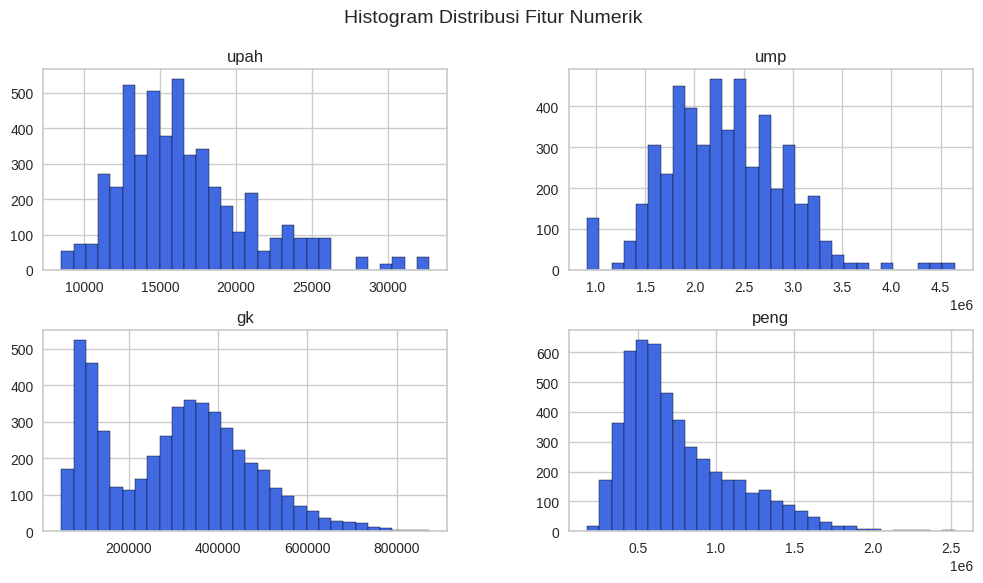

In [1161]:
# Histogram untuk melihat distribusi
plt.figure(figsize=(12, 6))
df_kesejahteraan[numerical_features].hist(figsize=(12, 6), bins=30, edgecolor="black", color="royalblue")
plt.suptitle("Histogram Distribusi Fitur Numerik", fontsize=14)
plt.show()

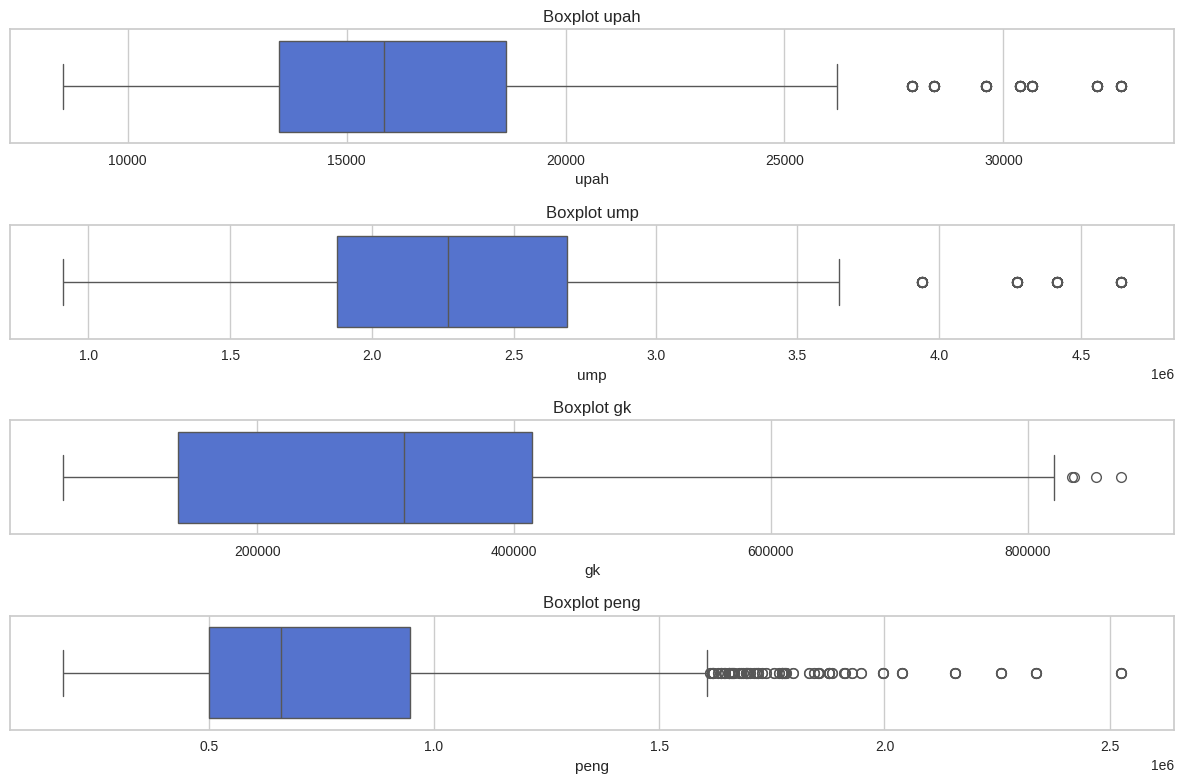

In [1162]:
# Boxplot untuk mendeteksi outlier
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(len(numerical_features), 1, i)
    sns.boxplot(x=df_kesejahteraan[col], color="royalblue")
    plt.title(f"Boxplot {col}")

plt.tight_layout()
plt.show()

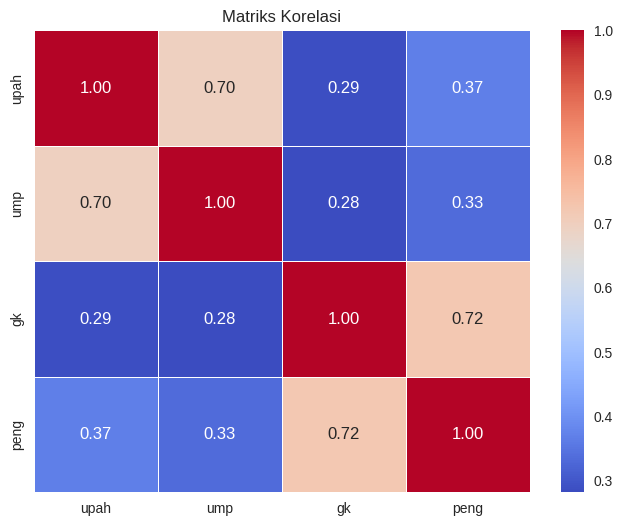

In [1163]:
# Matriks Korelasi
plt.figure(figsize=(8, 6))
sns.heatmap(df_kesejahteraan[numerical_features].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriks Korelasi")
plt.show()

### 4. Visualisasi Data

In [1164]:
# List variabel kategorikal
categorical_features = ["provinsi", "tahun", "jenis", "daerah", "periode"]

for col in categorical_features:
    print(f"Distribusi kategori untuk {col}:")
    print(df_kesejahteraan[col].value_counts(), "\n")

Distribusi kategori untuk provinsi:
provinsi
ACEH                    144
SUMATERA UTARA          144
SUMATERA BARAT          144
RIAU                    144
JAMBI                   144
SUMATERA SELATAN        144
BENGKULU                144
LAMPUNG                 144
KEP. BANGKA BELITUNG    144
KEP. RIAU               144
DKI JAKARTA             144
JAWA BARAT              144
JAWA TENGAH             144
DI YOGYAKARTA           144
JAWA TIMUR              144
BANTEN                  144
BALI                    144
NUSA TENGGARA BARAT     144
NUSA TENGGARA TIMUR     144
KALIMANTAN BARAT        144
KALIMANTAN TENGAH       144
KALIMANTAN SELATAN      144
KALIMANTAN TIMUR        144
KALIMANTAN UTARA        144
SULAWESI UTARA          144
SULAWESI TENGAH         144
SULAWESI SELATAN        144
SULAWESI TENGGARA       144
GORONTALO               144
SULAWESI BARAT          144
MALUKU                  144
MALUKU UTARA            144
PAPUA BARAT             144
PAPUA                   144
IND

<ipython-input-1165-8f15570df16f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_kesejahteraan, y=col, palette="Blues")


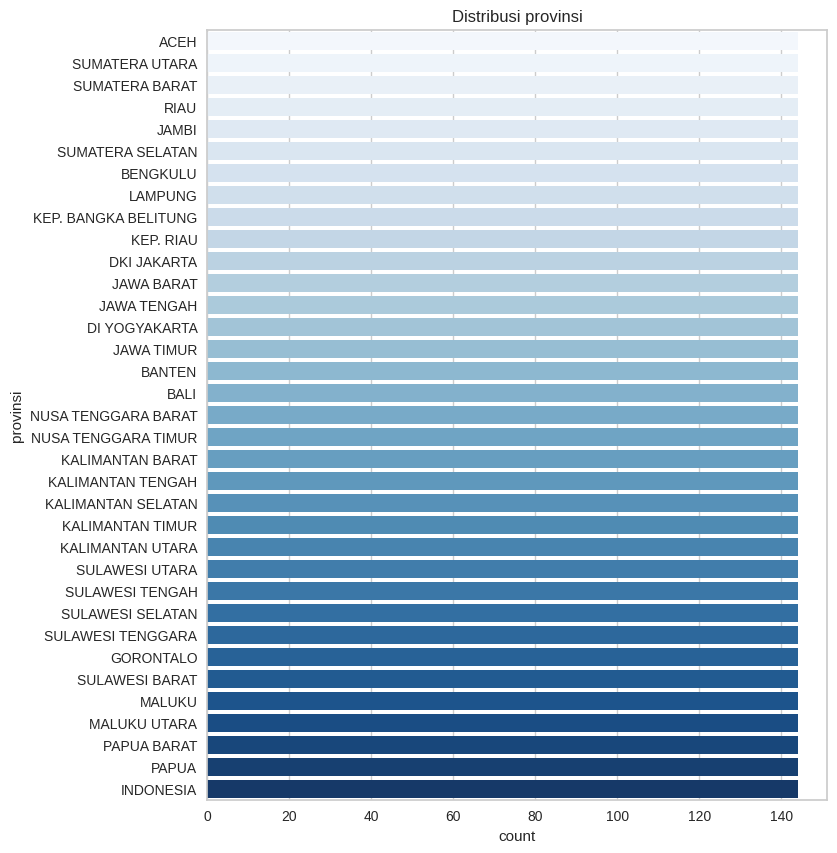

<ipython-input-1165-8f15570df16f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_kesejahteraan, y=col, palette="Blues")


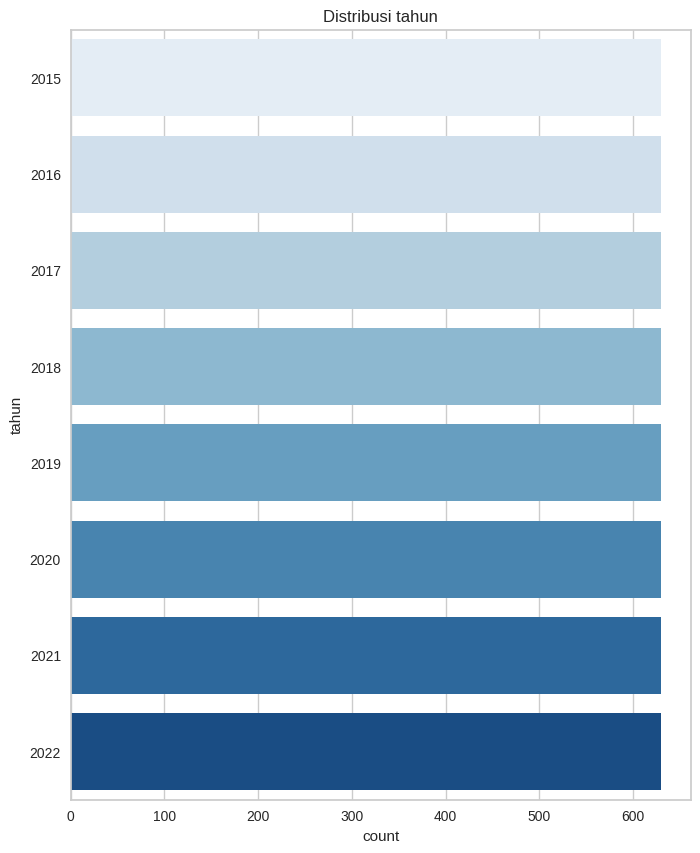

<ipython-input-1165-8f15570df16f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_kesejahteraan, y=col, palette="Blues")


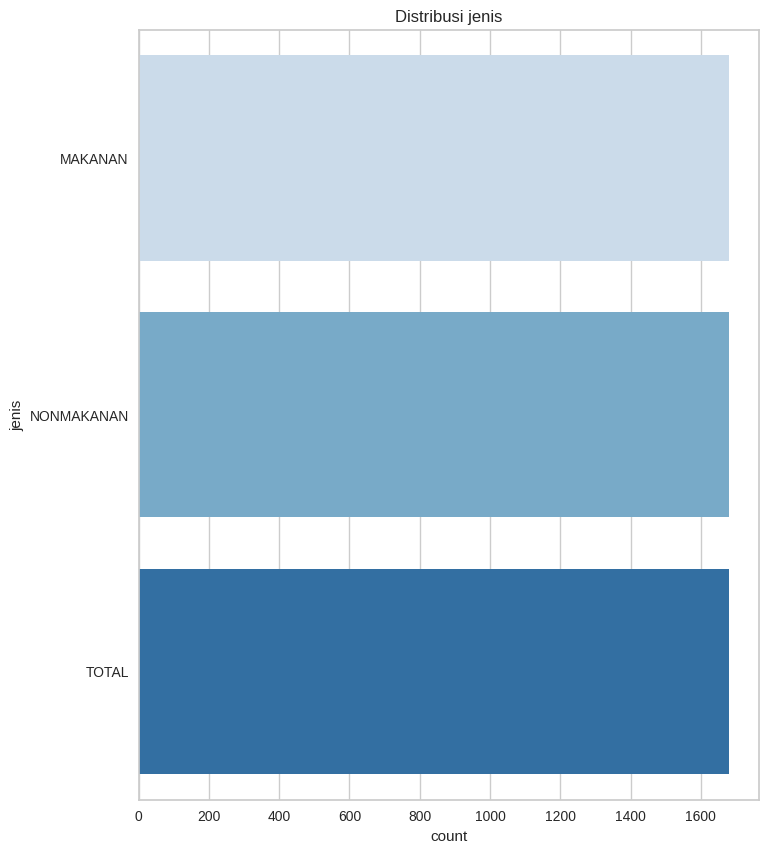

<ipython-input-1165-8f15570df16f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_kesejahteraan, y=col, palette="Blues")


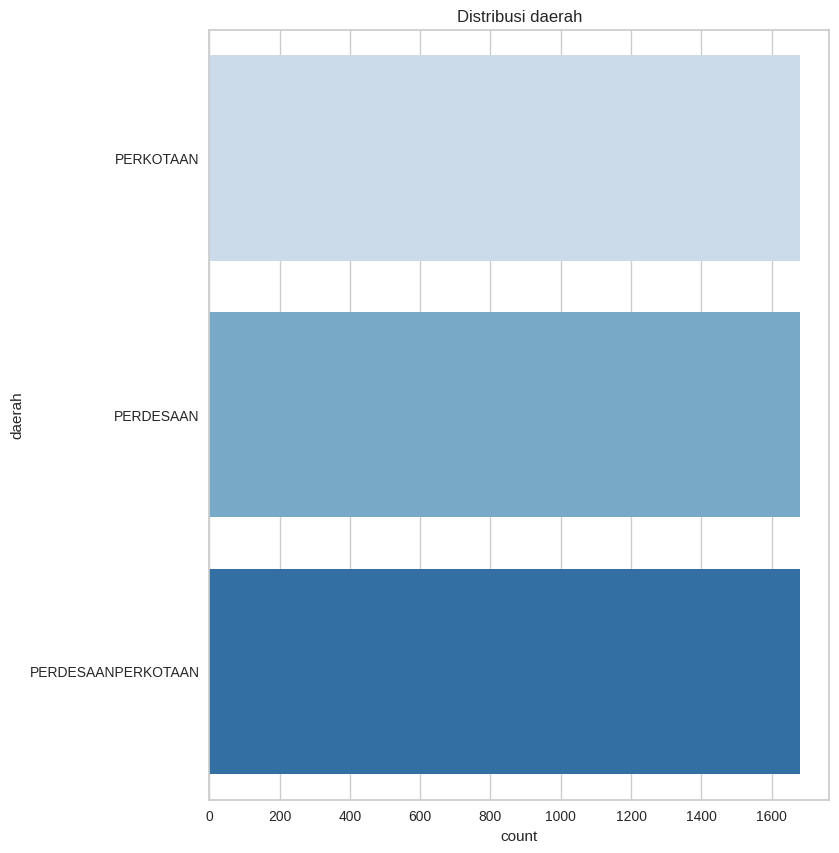

<ipython-input-1165-8f15570df16f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_kesejahteraan, y=col, palette="Blues")


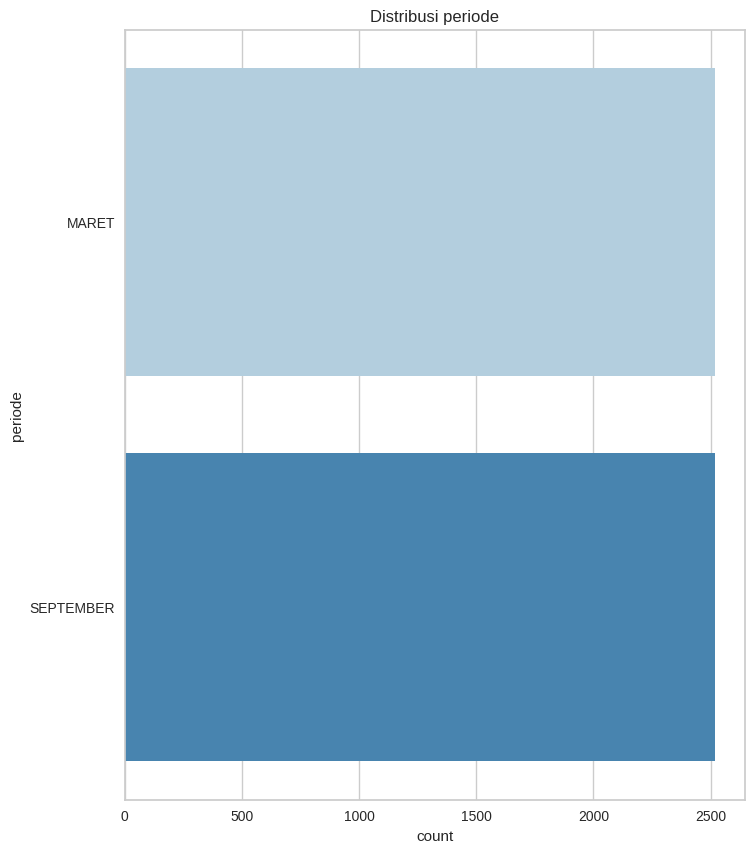

In [1165]:
# Countplot untuk visualisasi variabel kategorikal
for col in categorical_features:
    plt.figure(figsize=(8, 10))
    sns.countplot(data=df_kesejahteraan, y=col, palette="Blues")
    plt.title(f'Distribusi {col}')
    plt.show()

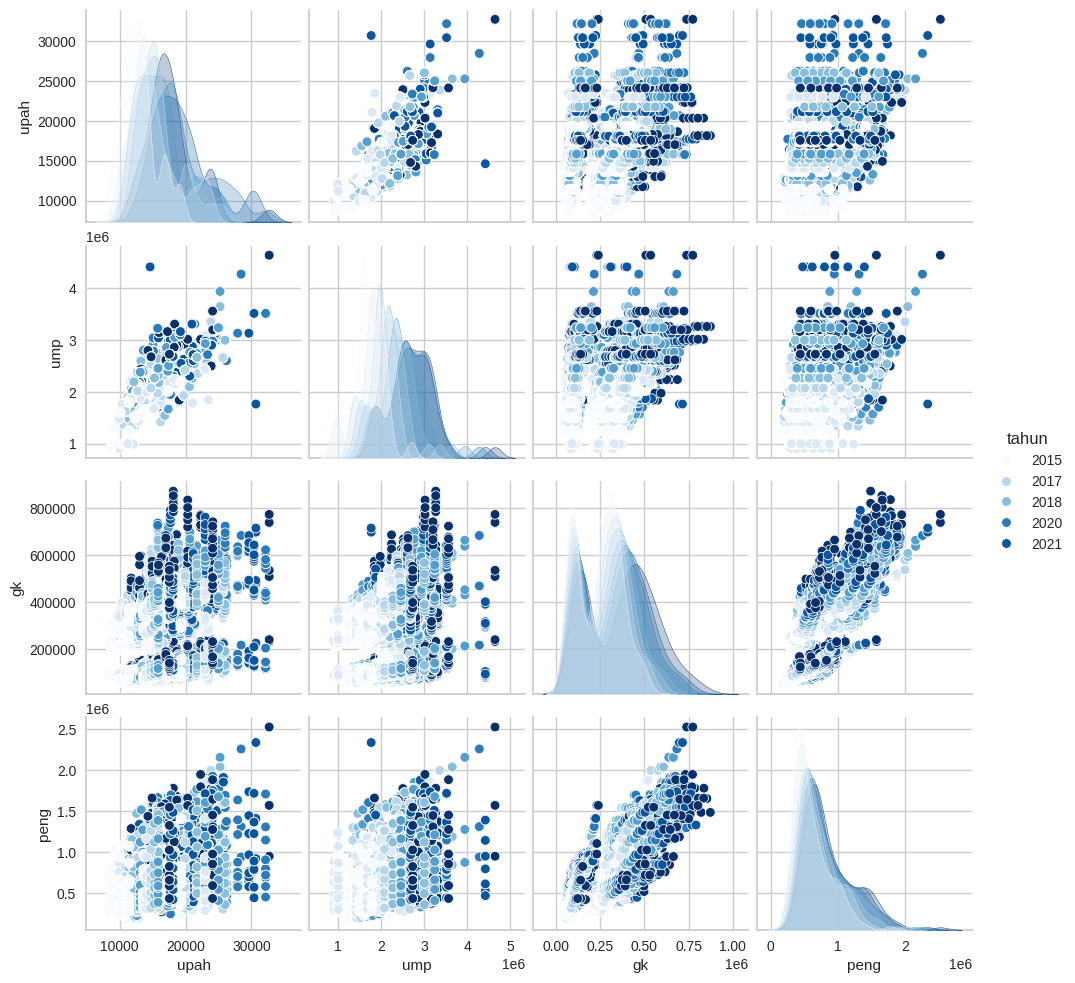

In [1166]:
# Pairplot untuk visualisasi korelasi antar variabel
sns.pairplot(df_kesejahteraan, hue="tahun", palette="Blues", diag_kind="kde")
plt.show()

# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning. Data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang bisa dilakukan, tetapi **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

Cukup sesuaikan dengan karakteristik data yang kamu gunakan yah.

In [1167]:
# Menangani Missing Values (Mengganti dengan Median)
df_kesejahteraan["gk"].fillna(df_kesejahteraan["gk"].median(), inplace=True)
df_kesejahteraan["peng"].fillna(df_kesejahteraan["peng"].median(), inplace=True)

<ipython-input-1167-043a8a9d58b7>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_kesejahteraan["gk"].fillna(df_kesejahteraan["gk"].median(), inplace=True)
<ipython-input-1167-043a8a9d58b7>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

In [1168]:
# Cek hasil penanganan missing values
print("\nMissing Values setelah penanganan:")
print(df_kesejahteraan.isnull().sum())


Missing Values setelah penanganan:
provinsi    0
tahun       0
upah        0
ump         0
jenis       0
daerah      0
periode     0
gk          0
peng        0
dtype: int64


In [1169]:
# Cek data duplikat
print("\nJumlah data duplikat:", df_kesejahteraan.duplicated().sum())


Jumlah data duplikat: 0


In [1170]:
# Normalisasi atau Standarisasi Fitur
scaler = StandardScaler()
numerical_features = ['upah', 'ump', 'gk', 'peng']
df_kesejahteraan[numerical_features] = scaler.fit_transform(df_kesejahteraan[numerical_features])

Melihat distribusi data pada histogram dan boxplot yang tadi:
- Distribusinya terlihat skewed pada beberapa fitur (terutama ump, gk, dan peng).
- Ada outliers yang cukup jauh dari distribusi utama — ini terlihat dari nilai di ujung boxplot yang menyebar cukup jauh.

In [1171]:
# Penanganan Outliers
for col in numerical_features:
    Q1 = df_kesejahteraan[col].quantile(0.25)
    Q3 = df_kesejahteraan[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Capping outliers
    df_kesejahteraan[col] = np.where((df_kesejahteraan[col] < lower_bound) | (df_kesejahteraan[col] > upper_bound),
                                     df_kesejahteraan[col].median(), df_kesejahteraan[col])

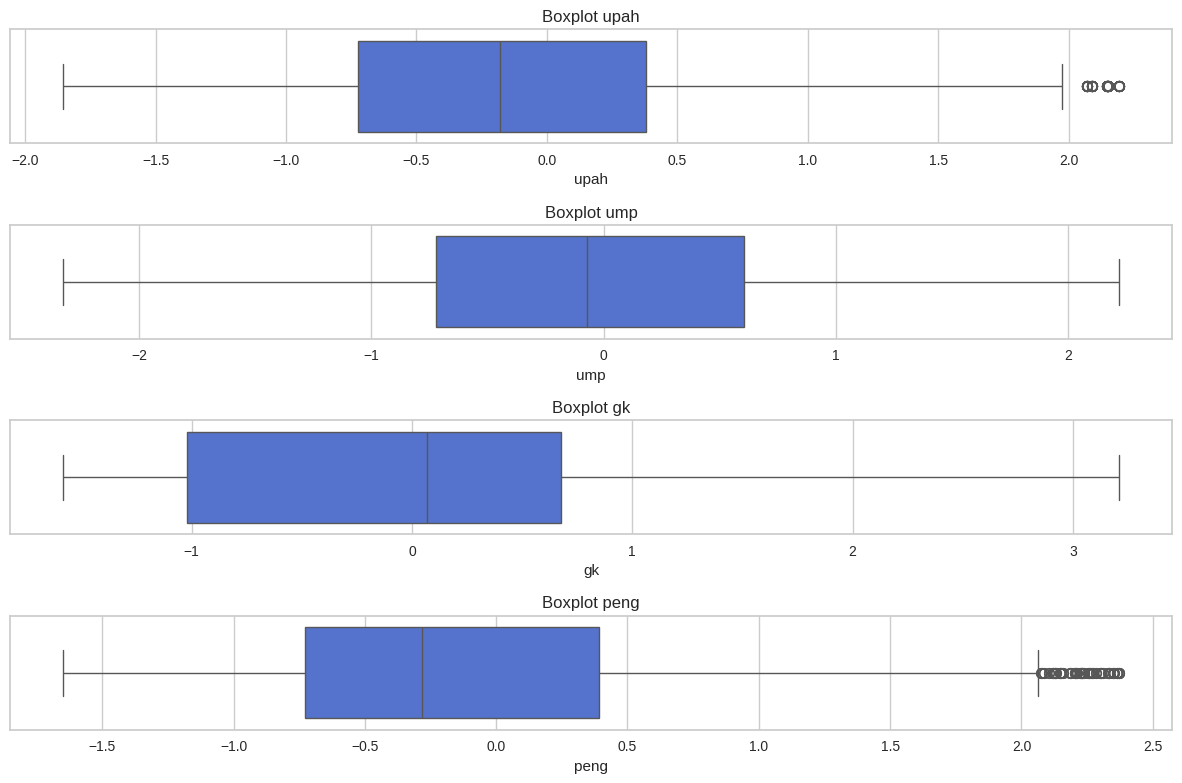

In [1172]:
# Cek hasil capping
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(len(numerical_features), 1, i)
    sns.boxplot(x=df_kesejahteraan[col], color="royalblue")
    plt.title(f"Boxplot {col}")

plt.tight_layout()
plt.show()

In [1173]:
# Encoding Data Kategorikal
categorical_features = ["provinsi", "tahun", "jenis", "daerah", "periode"]

# Copy dataframe agar tidak merusak data asli
df_encoded = df_kesejahteraan.copy()

# 1. Provinsi → Binary Encoding
encoder_provinsi = BinaryEncoder(cols=['provinsi'])
df_encoded = encoder_provinsi.fit_transform(df_encoded)

# 2. Tahun → Ordinal Encoding
encoder_tahun = OrdinalEncoder()
df_encoded['tahun'] = encoder_tahun.fit_transform(df_encoded[['tahun']])

# 3. Jenis → One-Hot Encoding
encoder_jenis = OneHotEncoder(drop='first', sparse_output=False)
encoded_jenis = encoder_jenis.fit_transform(df_encoded[['jenis']])
jenis_cols = encoder_jenis.get_feature_names_out(['jenis'])
df_encoded[jenis_cols] = encoded_jenis
df_encoded.drop('jenis', axis=1, inplace=True)

# 4. Daerah → Binary Encoding
encoder_daerah = BinaryEncoder(cols=['daerah'])
df_encoded = encoder_daerah.fit_transform(df_encoded)

# 5. Periode → Binary Encoding
encoder_periode = BinaryEncoder(cols=['periode'])
df_encoded = encoder_periode.fit_transform(df_encoded)

In [1174]:
# Rename kolom agar lebih terbaca jelas
df_encoded.rename(columns={
    'upah': 'Upah',
    'ump': 'Upah Minimum Provinsi',
    'gk': 'Garis Kemiskinan',
    'peng': 'Pengeluaran',
    'provinsi_0': 'Provinsi A',
    'provinsi_1': 'Provinsi B',
    'provinsi_2': 'Provinsi C',
    'provinsi_3': 'Provinsi D',
    'provinsi_4': 'Provinsi E',
    'provinsi_5': 'Provinsi F',
    'tahun': 'Tahun',
    'daerah_0': 'Daerah Perkotaan',
    'daerah_1': 'Daerah Pedesaan',
    'periode_0': 'Periode Maret',
    'periode_1': 'Periode September',
    'jenis_NONMAKANAN': 'Jenis Non-Makanan',
    'jenis_TOTAL': 'Jenis Gabungan'
}, inplace=True)

In [1175]:
# Cek hasil akhir
df_encoded.head()

,Provinsi A,Provinsi B,Provinsi C,Provinsi D,Provinsi E,Provinsi F,Tahun,Upah,Upah Minimum Provinsi,Daerah Perkotaan,Daerah Pedesaan,Periode Maret,Periode September,Garis Kemiskinan,Pengeluaran,Jenis Non-Makanan,Jenis Gabungan
0,0,0,0,0,0,1,0.0,-1.236257,-0.683252,0,1,0,1,-0.061423,-0.827777,0.0,0.0
1,0,0,0,0,0,1,0.0,-1.236257,-0.683252,0,1,1,0,-0.009053,-0.827777,0.0,0.0
2,0,0,0,0,0,1,0.0,-1.236257,-0.683252,1,0,0,1,-0.037931,-1.029453,0.0,0.0
3,0,0,0,0,0,1,0.0,-1.236257,-0.683252,1,0,1,0,0.019576,-1.029453,0.0,0.0
4,0,0,0,0,0,1,0.0,-1.236257,-0.683252,1,1,0,1,-0.044596,-0.972200,0.0,0.0


### 📝 **Deskripsi Data dan Encoding**
#### 1. **Tahun** (Ordinal Encoding)  
Kolom **Tahun** dikodekan menggunakan ordinal encoding karena memiliki urutan yang jelas:  

| Nilai Encoding | Tahun Asli |
|---------------|------------|
| **0**          | 2015        |
| **1**          | 2016        |
| **2**          | 2017        |
| **3**          | 2018        |
| **4**          | 2019        |
| **5**          | 2020        |
| **6**          | 2021        |
| **7**          | 2022        |

#### 2. **Provinsi** (Binary Encoding)  
Kolom **Provinsi** dikodekan menggunakan binary encoding karena jumlah kategori banyak dan tidak memiliki urutan. Hasil encoding menghasilkan enam kolom biner (`Provinsi A` s/d `Provinsi F`):  

| Kolom `Provinsi A` | Kolom `Provinsi B` | Kolom `Provinsi C` | Kolom `Provinsi D` | Kolom `Provinsi E` | Kolom `Provinsi F` | Provinsi Asli            |
|--------------------|--------------------|--------------------|--------------------|--------------------|--------------------|-------------------------|
| 0                  | 0                  | 0                  | 0                  | 0                  | 1                  | Aceh                    |
| 0                  | 0                  | 0                  | 0                  | 0                  | 1                  | Sumatera Utara          |
| 0                  | 0                  | 0                  | 0                  | 0                  | 1                  | Sumatera Barat          |
| 0                  | 0                  | 0                  | 0                  | 0                  | 1                  | Riau                    |
| ...                | ...                | ...                | ...                | ...                | ...                | ...                     |

👉 **Keterangan**:  
- Hasil encoding hanya terlihat dalam 6 kolom biner karena binary encoding memetakan data kategori menjadi representasi biner.  
- Kombinasi nilai biner pada **Provinsi A** s/d **Provinsi F** merepresentasikan provinsi asli.  
- Nilai biner `0` dan `1` menunjukkan status aktif atau tidaknya pada kolom tersebut.  
---

#### 3. **Jenis** (One-Hot Encoding)  
Kolom **Jenis** dikodekan menggunakan one-hot encoding karena hanya terdiri dari tiga kategori eksklusif (Makanan, Non-Makanan, Gabungan):  

| Kolom `Jenis Non-Makanan` | Kolom `Jenis Gabungan` | Keterangan         |
|---------------------------|------------------------|--------------------|
| **0**                     | **0**                  | Makanan            |
| **1**                     | **0**                  | Non Makanan        |
| **0**                     | **1**                  | Gabungan (Total)   |

👉 **Keterangan**:  
- Jika semua kolom bernilai **0**, maka kategori adalah **Makanan**.  
- Jika kolom `Jenis Non-Makanan` bernilai **1**, maka itu adalah kategori **Non-Makanan**.  
- Jika kolom `Jenis Gabungan` bernilai **1**, maka itu adalah kategori **Gabungan (Total)**.  
---

#### 4. **Daerah** (Binary Encoding)  
Kolom **Daerah** dikodekan menggunakan binary encoding karena terdiri dari dua kategori (Perkotaan dan Pedesaan):  

| Kolom `Daerah Perkotaan` | Kolom `Daerah Pedesaan` | Keterangan          |
|--------------------------|-------------------------|---------------------|
| **0**                    | **1**                   | Pedesaan            |
| **1**                    | **0**                   | Perkotaan           |

## 5. **Periode** (Binary Encoding)  
Kolom **Periode** dikodekan menggunakan binary encoding karena hanya terdiri dari dua kategori (Maret dan September):  

| Kolom `Periode Maret` | Kolom `Periode September` | Keterangan           |
|-----------------------|---------------------------|----------------------|
| **0**                 | **1**                     | September            |
| **1**                 | **0**                     | Maret                |



Note : Saya tidak melakukan binning karena akan memakai K-Means dan butuh data kontinu

# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

Pada tahap ini, Anda membangun model clustering dengan memilih algoritma yang sesuai untuk mengelompokkan data berdasarkan kesamaan. Berikut adalah **rekomendasi** tahapannya.
1. Pilih algoritma clustering yang sesuai.
2. Latih model dengan data menggunakan algoritma tersebut.

In [1176]:
# Membuat model K-Means
kmeans = KMeans(n_clusters=4, random_state=42)

# Melatih model pada dataset
kmeans.fit(df_encoded)

# Menambahkan hasil cluster ke dalam DataFrame
df_encoded['Cluster'] = kmeans.labels_

# Melihat hasil jumlah data per cluster
cluster_counts = df_encoded['Cluster'].value_counts()
print(cluster_counts)

Cluster
2    1559
0    1485
1    1118
3     878
Name: count, dtype: int64


In [1177]:
# Melihat karakteristik tiap cluster
cluster_summary = df_encoded.groupby('Cluster').mean()
print(cluster_summary)

         Provinsi A  Provinsi B  Provinsi C  Provinsi D  Provinsi E  \
Cluster                                                               
0          0.099663    0.464646    0.465993    0.492256    0.516498   
1          0.100179    0.474061    0.461538    0.482111    0.523256   
2          0.122514    0.454137    0.454779    0.432328    0.514432   
3          0.142369    0.428246    0.440774    0.410023    0.498861   

         Provinsi F     Tahun      Upah  Upah Minimum Provinsi  \
Cluster                                                          
0          0.496296  0.748822 -0.666387              -0.891131   
1          0.511628  5.975850  0.239096               0.453566   
2          0.528544  3.061578 -0.043161               0.000125   
3          0.522779  5.779043  0.425379               0.650168   

         Daerah Perkotaan  Daerah Pedesaan  Periode Maret  Periode September  \
Cluster                                                                        
0               

## **b. Evaluasi Model Clustering**

Untuk menentukan jumlah cluster yang optimal dalam model clustering, Anda dapat menggunakan metode Elbow atau Silhouette Score.

Metode ini membantu kita menemukan jumlah cluster yang memberikan pemisahan terbaik antar kelompok data, sehingga model yang dibangun dapat lebih efektif. Berikut adalah **rekomendasi** tahapannya.
1. Gunakan Silhouette Score dan Elbow Method untuk menentukan jumlah cluster optimal.
2. Hitung Silhouette Score sebagai ukuran kualitas cluster.

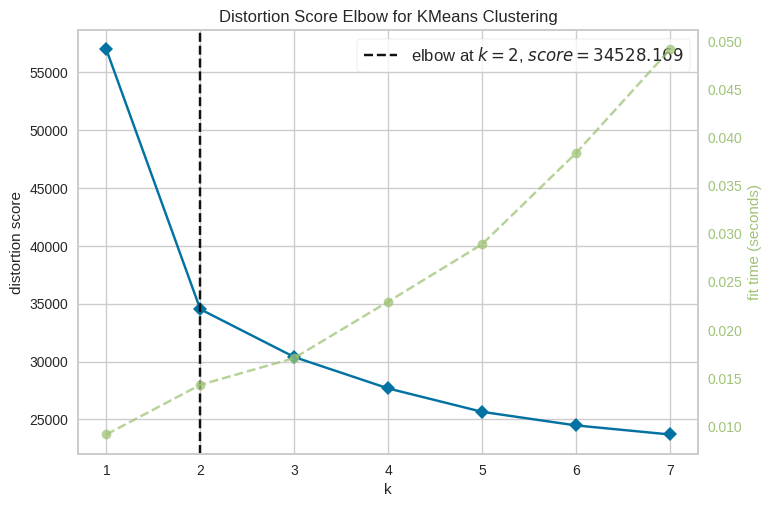

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [1178]:
# Menggunakan Elbow Method untuk menentukan jumlah cluster optimal.
df_encoded = df_encoded.drop('Cluster', axis=1)

# Buat model KMeans
kmeans = KMeans(random_state=42)

# Visualisasi dengan KElbowVisualizer untuk menentukan jumlah cluster optimal (1 sampai 10)
visualizer = KElbowVisualizer(kmeans, k=(1, 8))

# Masukkan data yang sudah di-encode
visualizer.fit(df_encoded)
visualizer.show()

In [1179]:
# Menghitung silhouette score dari hasil Elbow method
n_clusters = visualizer.elbow_value_

# Latih ulang model dengan jumlah cluster dari Elbow
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(df_encoded)

# Hitung silhouette score
silhouette_avg = silhouette_score(df_encoded, kmeans.labels_)
print(f"Silhouette Score untuk {n_clusters} cluster: {silhouette_avg:.3f}")

Silhouette Score untuk 2 cluster: 0.318


Silhouette Score untuk K = 2: 0.318
Silhouette Score untuk K = 3: 0.191
Silhouette Score untuk K = 4: 0.168
Silhouette Score untuk K = 5: 0.162
Silhouette Score untuk K = 6: 0.147
Silhouette Score untuk K = 7: 0.133


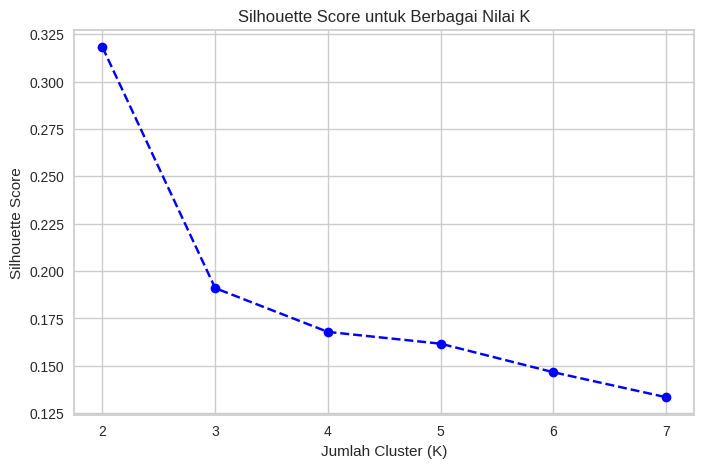

In [1180]:
# Menggunakan silhouette score untuk menentukan jumlah cluster optimal.
silhouette_scores = []
K = range(2, 8)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_encoded)
    score = silhouette_score(df_encoded, labels)
    silhouette_scores.append(score)
    print(f"Silhouette Score untuk K = {k}: {score:.3f}")

# Plot Silhouette Scores
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_scores, marker='o', linestyle='--', color='blue')
plt.title('Silhouette Score untuk Berbagai Nilai K')
plt.xlabel('Jumlah Cluster (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

## **c. Feature Selection (Opsional)**

Silakan lakukan feature selection jika Anda membutuhkan optimasi model clustering. Jika Anda menerapkan proses ini, silakan lakukan pemodelan dan evaluasi kembali menggunakan kolom-kolom hasil feature selection. Terakhir, bandingkan hasil performa model sebelum dan sesudah menerapkan feature selection.

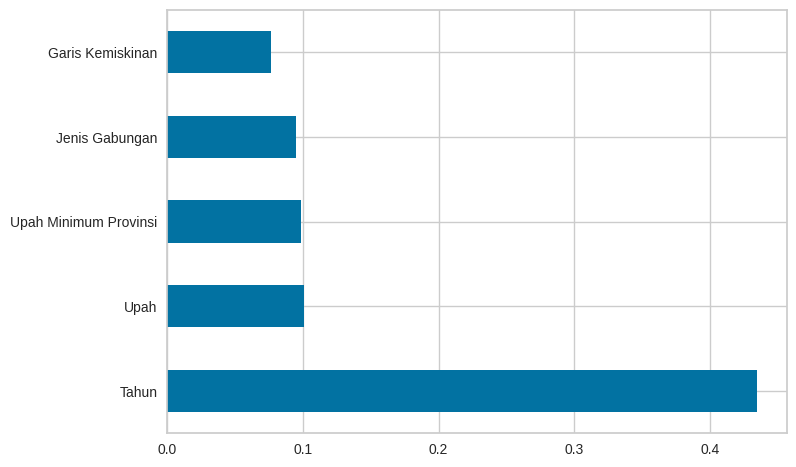

In [1181]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(df_encoded, kmeans.labels_)

# Urutkan fitur berdasarkan kepentingannya
feat_importances = pd.Series(model.feature_importances_, index=df_encoded.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

In [1182]:
# Pilih fitur terbaik berdasarkan importance
selected_features = ['Tahun', 'Upah Minimum Provinsi', 'Upah', 'Jenis Gabungan', 'Garis Kemiskinan']
X_selected = df_encoded[selected_features]

In [1183]:
# Jumlah cluster berdasarkan hasil metode elbow diatas
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_selected)

# Evaluasi hasil clustering
silhouette = silhouette_score(X_selected, kmeans.labels_)
print(f"Silhouette Score setelah Feature Selection: {silhouette:.3f}")

Silhouette Score setelah Feature Selection: 0.440


## **d. Visualisasi Hasil Clustering**

Setelah model clustering dilatih dan jumlah cluster optimal ditentukan, langkah selanjutnya adalah menampilkan hasil clustering melalui visualisasi.

Berikut adalah **rekomendasi** tahapannya.
1. Tampilkan hasil clustering dalam bentuk visualisasi, seperti grafik scatter plot atau 2D PCA projection.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


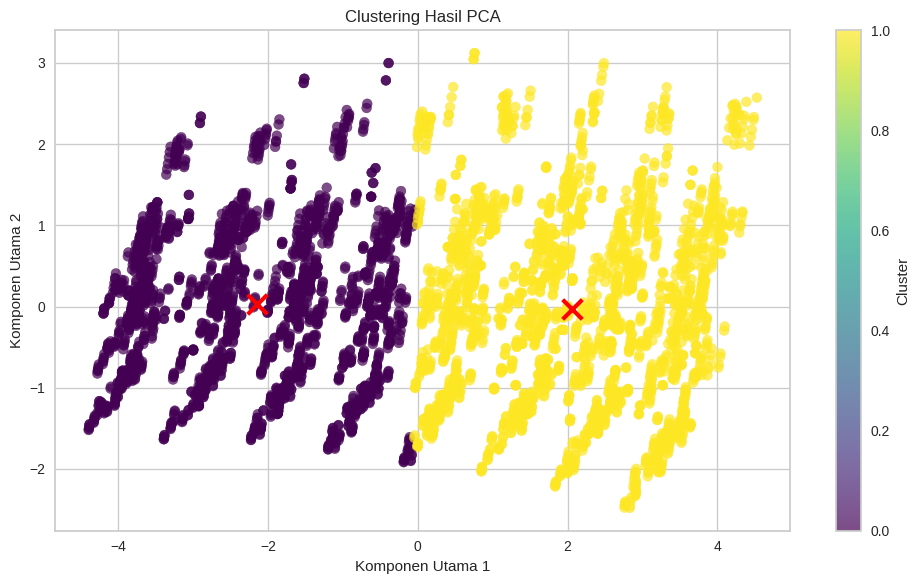

Variance explained:
Komponen 1: 72.56%
Komponen 2: 13.44%


In [1184]:
# Reduksi dimensi menggunakan PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_selected)

# Buat scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                      c=kmeans.labels_,
                      cmap='viridis',
                      alpha=0.7,
                      s=50)

# Tambahkan centroid cluster
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
            c='red',
            marker='x',
            s=200,
            linewidths=3)

plt.title('Clustering Hasil PCA')
plt.xlabel('Komponen Utama 1')
plt.ylabel('Komponen Utama 2')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

# Tambahan: Print variance explained
print("Variance explained:")
print(f"Komponen 1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"Komponen 2: {pca.explained_variance_ratio_[1]*100:.2f}%")

## **e. Analisis dan Interpretasi Hasil Cluster**

### Interpretasi Target

**Tutorial: Melakukan Inverse Transform pada Data Target Setelah Clustering**

Setelah melakukan clustering dengan model **KMeans**, kita perlu mengembalikan data yang telah diubah (normalisasi, standarisasi, atau label encoding) ke bentuk aslinya. Berikut adalah langkah-langkahnya.

---

**1. Tambahkan Hasil Label Cluster ke DataFrame**
Setelah mendapatkan hasil clustering, kita tambahkan label cluster ke dalam DataFrame yang telah dinormalisasi.

```python
df_normalized['Cluster'] = model_kmeans.labels_
```

Lakukan Inverse Transform pada feature yang sudah dilakukan Labelisasi dan Standararisasi. Berikut code untuk melakukannya:
label_encoder.inverse_transform(X_Selected[['Fitur']])

Lalu masukkan ke dalam kolom dataset asli atau membuat dataframe baru
```python
df_normalized['Fitur'] = label_encoder.inverse_transform(df_normalized[['Fitur']])
```
Masukkan Data yang Sudah Di-Inverse ke dalam Dataset Asli atau Buat DataFrame Baru
```python
df_original['Fitur'] = df_normalized['Fitur']
```

In [1185]:
# Tambahkan hasil cluster ke dalam DataFrame
df_encoded['Cluster'] = kmeans.labels_

# Tampilkan beberapa baris pertama untuk memastikan hasilnya
df_encoded.head()

,Provinsi A,Provinsi B,Provinsi C,Provinsi D,Provinsi E,Provinsi F,Tahun,Upah,Upah Minimum Provinsi,Daerah Perkotaan,Daerah Pedesaan,Periode Maret,Periode September,Garis Kemiskinan,Pengeluaran,Jenis Non-Makanan,Jenis Gabungan,Cluster
0,0,0,0,0,0,1,0.0,-1.236257,-0.683252,0,1,0,1,-0.061423,-0.827777,0.0,0.0,0
1,0,0,0,0,0,1,0.0,-1.236257,-0.683252,0,1,1,0,-0.009053,-0.827777,0.0,0.0,0
2,0,0,0,0,0,1,0.0,-1.236257,-0.683252,1,0,0,1,-0.037931,-1.029453,0.0,0.0,0
3,0,0,0,0,0,1,0.0,-1.236257,-0.683252,1,0,1,0,0.019576,-1.029453,0.0,0.0,0
4,0,0,0,0,0,1,0.0,-1.236257,-0.683252,1,1,0,1,-0.044596,-0.972200,0.0,0.0,0


### Inverse Data Jika Melakukan Normalisasi/Standardisasi

Inverse Transform untuk Data yang Distandarisasi
Jika data numerik telah dinormalisasi menggunakan StandardScaler atau MinMaxScaler, kita bisa mengembalikannya ke skala asli:
```python
df_normalized[['Fitur_Numerik']] = scaler.inverse_transform(df_normalized[['Fitur_Numerik']])
```

In [1186]:
# Inverse transform untuk fitur yang distandarisasi
df_encoded[['Upah Minimum Provinsi', 'Upah', 'Garis Kemiskinan', 'Pengeluaran']] = scaler.inverse_transform(
    df_encoded[['Upah Minimum Provinsi', 'Upah', 'Garis Kemiskinan', 'Pengeluaran']]
)

In [1187]:
# Inverse transform untuk Tahun (Ordinal Encoding)
df_encoded['Tahun'] = encoder_tahun.inverse_transform(df_encoded[['Tahun']])

In [1188]:
# Kembalikan kolom 'Jenis' ke bentuk aslinya
df_encoded['Jenis'] = df_encoded.apply(
    lambda row: 'Makanan' if row['Jenis Non-Makanan'] == 0 and row['Jenis Gabungan'] == 0
    else 'Non-Makanan' if row['Jenis Non-Makanan'] == 1
    else 'Gabungan (Total)', axis=1
)

# Hapus kolom one-hot encoding setelah dikembalikan
df_encoded.drop(columns=['Jenis Non-Makanan', 'Jenis Gabungan'], inplace=True)

In [1189]:
# List nama provinsi sesuai urutan
nama_provinsi = [
    "ACEH", "SUMATERA UTARA", "SUMATERA BARAT", "RIAU", "JAMBI", "SUMATERA SELATAN",
    "BENGKULU", "LAMPUNG", "KEP. BANGKA BELITUNG", "KEP. RIAU", "DKI JAKARTA", "JAWA BARAT",
    "JAWA TENGAH", "DI YOGYAKARTA", "JAWA TIMUR", "BANTEN", "BALI", "NUSA TENGGARA BARAT",
    "NUSA TENGGARA TIMUR", "KALIMANTAN BARAT", "KALIMANTAN TENGAH", "KALIMANTAN SELATAN",
    "KALIMANTAN TIMUR", "KALIMANTAN UTARA", "SULAWESI UTARA", "SULAWESI TENGAH",
    "SULAWESI SELATAN", "SULAWESI TENGGARA", "GORONTALO", "SULAWESI BARAT", "MALUKU",
    "MALUKU UTARA", "PAPUA BARAT", "PAPUA", "INDONESIA"
]

# Konversi nilai biner ke angka desimal
df_encoded['Provinsi_Index'] = df_encoded[['Provinsi A', 'Provinsi B', 'Provinsi C', 'Provinsi D', 'Provinsi E', 'Provinsi F']].apply(
    lambda row: int("".join(map(str, row.values.astype(int))), 2), axis=1
)

# Mapping kembali ke nama provinsi
df_encoded['Provinsi'] = df_encoded['Provinsi_Index'].apply(lambda x: nama_provinsi[x - 1] if 1 <= x <= len(nama_provinsi) else None)

# Hapus kolom indeks sementara dan kolom biner (A-F)
df_encoded.drop(columns=['Provinsi_Index', 'Provinsi A', 'Provinsi B', 'Provinsi C', 'Provinsi D', 'Provinsi E', 'Provinsi F'], inplace=True)

In [1190]:
# Mapping Daerah berdasarkan nilai biner
df_encoded['Daerah'] = df_encoded[['Daerah Perkotaan', 'Daerah Pedesaan']].apply(
    lambda row: "Pedesaan & Perkotaan" if row['Daerah Perkotaan'] == 1 and row['Daerah Pedesaan'] == 1 else
    ("Perkotaan" if row['Daerah Perkotaan'] == 1 else "Pedesaan"), axis=1
)

# Mapping Periode berdasarkan nilai biner
df_encoded['Periode'] = df_encoded[['Periode Maret', 'Periode September']].apply(
    lambda row: "Maret" if row['Periode Maret'] == 1 else "September", axis=1
)

# Hapus kolom biner setelah decoding
df_encoded.drop(columns=[
    'Daerah Perkotaan', 'Daerah Pedesaan',
    'Periode Maret', 'Periode September'
], inplace=True)

In [1191]:
# Tampilkan beberapa baris pertama untuk memastikan hasilnya
df_encoded.head()

,Tahun,Upah,Upah Minimum Provinsi,Garis Kemiskinan,Pengeluaran,Cluster,Jenis,Provinsi,Daerah,Periode
0,2015,1.567050e+06,13639.305166,293697.0,466355.0,0,Makanan,ACEH,Pedesaan,September
1,2015,1.567050e+06,13639.305166,302128.0,466355.0,0,Makanan,ACEH,Pedesaan,Maret
2,2015,1.567050e+06,13639.305166,297479.0,395136.0,0,Makanan,ACEH,Perkotaan,September
3,2015,1.567050e+06,13639.305166,306737.0,395136.0,0,Makanan,ACEH,Perkotaan,Maret
4,2015,1.567050e+06,13639.305166,296406.0,415354.0,0,Makanan,ACEH,Pedesaan & Perkotaan,September


Setelah melakukan clustering, langkah selanjutnya adalah menganalisis karakteristik dari masing-masing cluster berdasarkan fitur yang tersedia.

Berikut adalah **rekomendasi** tahapannya.
1. Analisis karakteristik tiap cluster berdasarkan fitur yang tersedia (misalnya, distribusi nilai dalam cluster).
2. Berikan interpretasi: Apakah hasil clustering sesuai dengan ekspektasi dan logika bisnis? Apakah ada pola tertentu yang bisa dimanfaatkan?

In [1192]:
# Hanya kolom numerik yang dihitung mean-nya
numerical_columns = df_encoded.select_dtypes(include=np.number).columns
categorical_columns = df_encoded.select_dtypes(exclude=np.number).columns

# Lakukan agregasi pada setiap cluster
cluster_summary = df_encoded.groupby('Cluster')[numerical_columns].mean()

# Tambahkan mode untuk kolom kategori
for col in categorical_columns:
    cluster_summary[col] = df_encoded.groupby('Cluster')[col].agg(lambda x: x.mode()[0] if not x.mode().empty else None)

# Tampilkan hasilnya
print(cluster_summary)

               Tahun          Upah  Upah Minimum Provinsi  Garis Kemiskinan  \
Cluster                                                                       
0        2016.474838  2.034864e+06           14029.136714     259198.276380   
1        2020.437112  2.478605e+06           18684.800662     345212.361025   

           Pengeluaran  Cluster             Jenis       Provinsi  \
Cluster                                                            
0        657243.101867      0.0       Non-Makanan  DI YOGYAKARTA   
1        796206.592003      1.0  Gabungan (Total)    DKI JAKARTA   

                       Daerah Periode  
Cluster                                
0        Pedesaan & Perkotaan   Maret  
1                    Pedesaan   Maret  


In [1193]:
# Analisis distribusi jumlah anggota tiap cluster
print("\nDistribusi jumlah anggota dalam tiap cluster:")
print(df_encoded['Cluster'].value_counts())


Distribusi jumlah anggota dalam tiap cluster:
Cluster
1    2576
0    2464
Name: count, dtype: int64


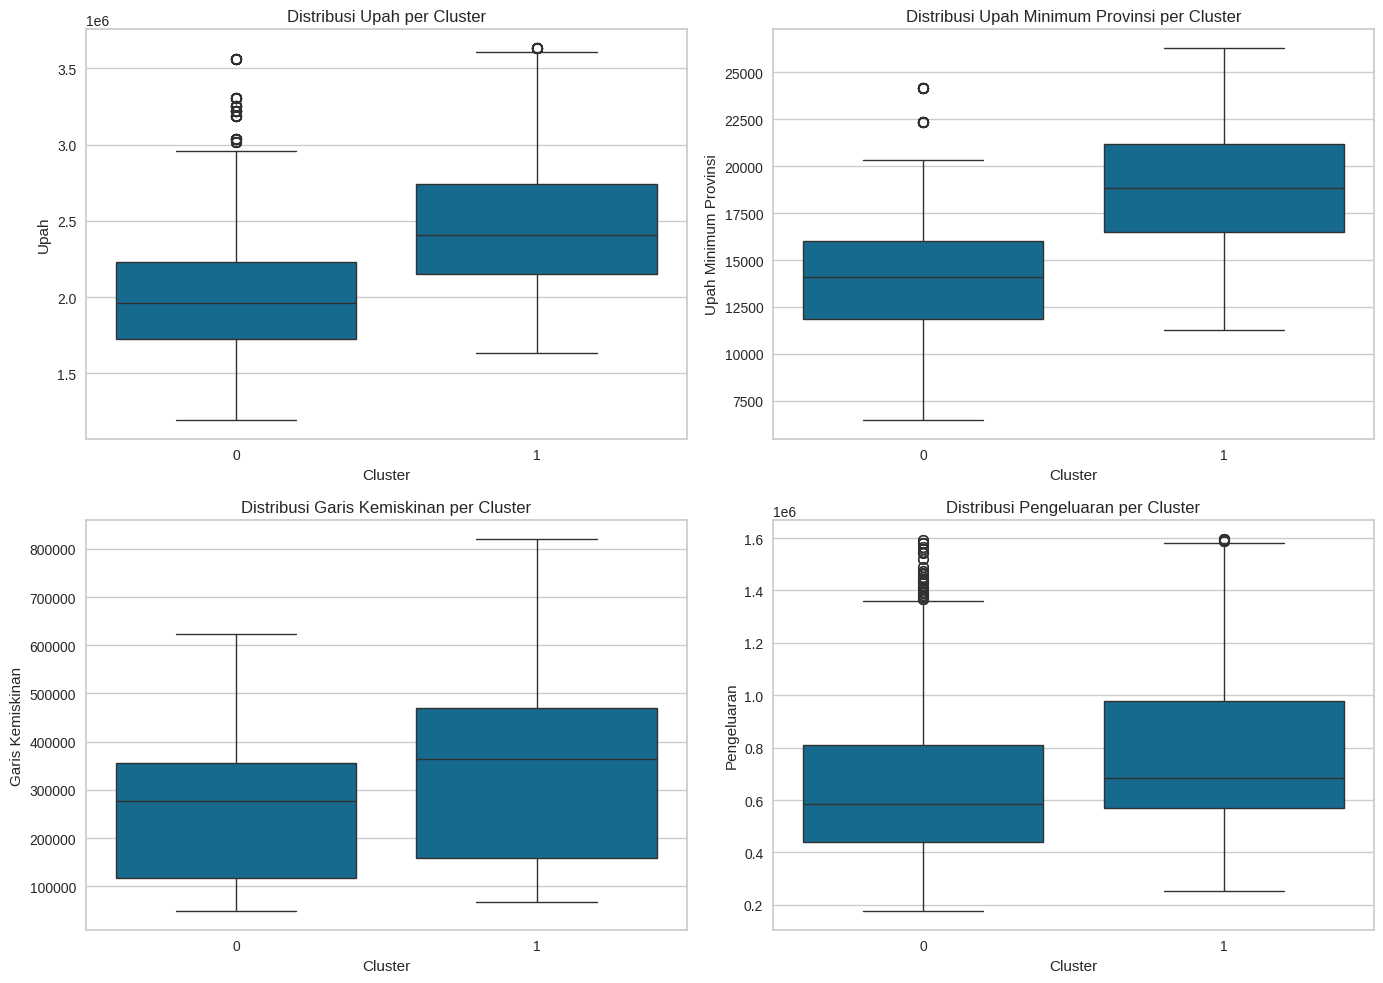

In [1194]:
# Bentuk Visualisasi nya
# List fitur numerik yang akan divisualisasikan
numerical_features = ['Upah', 'Upah Minimum Provinsi', 'Garis Kemiskinan', 'Pengeluaran']

# Buat subplots untuk setiap fitur numerik
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.boxplot(x='Cluster', y=feature, data=df_encoded, ax=axes[i])
    axes[i].set_title(f'Distribusi {feature} per Cluster')

plt.tight_layout()
plt.show()

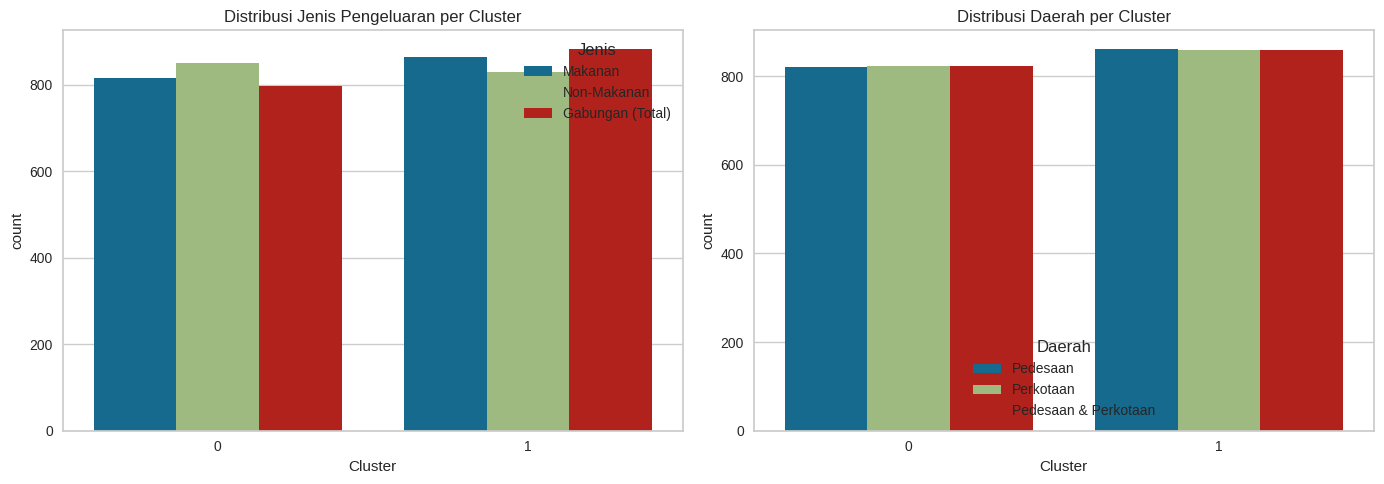

In [1195]:
# Visualisasi kolom kategorikal
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Jenis pengeluaran
sns.countplot(x="Cluster", hue="Jenis", data=df_encoded, ax=axes[0])
axes[0].set_title("Distribusi Jenis Pengeluaran per Cluster")

# Daerah
sns.countplot(x="Cluster", hue="Daerah", data=df_encoded, ax=axes[1])
axes[1].set_title("Distribusi Daerah per Cluster")

plt.tight_layout()
plt.show()

In [1196]:
# Agregasi untuk fitur yang dipakai pada model
aggregated_data = df_encoded.groupby('Cluster').agg({
    'Tahun': ['min', 'max', 'mean'],
    'Upah Minimum Provinsi': ['min', 'max', 'mean'],
    'Upah': ['min', 'max', 'mean'],
    'Garis Kemiskinan': ['min', 'max', 'mean'],
    'Jenis': lambda x: x.mode()[0]  # Ambil modus
})

# Tampilkan hasil agregasi
aggregated_data

Tahun                    Upah Minimum Provinsi                \
          min   max         mean                   min           max   
Cluster                                                                
0        2015  2019  2016.474838           6463.540253  24190.941300   
1        2018  2022  2020.437112          11254.073661  26309.502536   

                               Upah                              \
                 mean           min           max          mean   
Cluster                                                           
0        14029.136714  1.194408e+06  3.558014e+06  2.034864e+06   
1        18684.800662  1.637136e+06  3.632653e+06  2.478605e+06   

        Garis Kemiskinan                                      Jenis  
                     min       max           mean          <lambda>  
Cluster                                                              
0                48561.0  623111.0  259198.276380       Non-Makanan  
1                67608.0  820543.0  345212.361025  Gabungan (Total)

# Analisis Karakteristik Cluster dari Model KMeans
## 1. Cluster 0:
- **Tahun** rata-rata 2016, dengan rentang antara 2015 - 2019.
- **Upah Minimum Provinsi** rata-rata Rp14.029.136, dengan rentang Rp6.463.540 - Rp24.190.941.
- **Upah** rata-rata Rp2.034.864, dengan rentang Rp1.194.408 - Rp3.558.014.
- **Garis Kemiskinan** rata-rata Rp259.198, dengan rentang Rp48.561 - Rp623.111.
- **Jenis** yang paling sering muncul: Non-Makanan.
#### Analisis:
- Klaster ini mencerminkan daerah dengan **ekonomi berkembang**, di mana upah masih relatif rendah dan garis kemiskinan lebih tinggi dibandingkan klaster lainnya.
- Sebagian besar pengeluaran dalam klaster ini adalah untuk kebutuhan non-makanan, yang bisa mengindikasikan bahwa masyarakat lebih banyak mengalokasikan pendapatan mereka untuk kebutuhan sekunder.
- Periode waktu dalam klaster ini lebih dominan di tahun 2015 - 2019, yang bisa berarti bahwa data ini banyak berasal dari periode sebelum kebijakan kenaikan upah yang signifikan di beberapa daerah.


## 2. Cluster 1:
- **Tahun** rata-rata 2020, dengan rentang antara 2018 - 2022.
- **Upah Minimum Provinsi** rata-rata Rp18.684.800, dengan rentang Rp11.254.073 - Rp26.309.502.
- **Upah** rata-rata Rp2.478.605, dengan rentang Rp1.637.136 - Rp3.632.653.
- **Garis Kemiskinan** rata-rata Rp345.212, dengan rentang Rp67.608 - Rp820.543.
- **Jenis** yang paling sering muncul: Gabungan (Total).

#### Analisis:
- Klaster ini menggambarkan daerah dengan **ekonomi lebih maju**, di mana upah minimum dan upah rata-rata lebih tinggi dibandingkan klaster lainnya.
- Garis kemiskinan juga lebih tinggi, yang bisa mencerminkan bahwa biaya hidup di daerah ini lebih mahal atau standar kebutuhan dasar lebih tinggi.
- Kategori Jenis yang dominan adalah Gabungan (Total), yang bisa menunjukkan bahwa masyarakat di daerah ini memiliki pola konsumsi yang lebih berimbang antara makanan dan non-makanan.
- Data dalam klaster ini lebih banyak berasal dari periode yang lebih baru (2018 - 2022), yang mungkin dipengaruhi oleh peningkatan upah di tahun-tahun terbaru.



## Kesimpulan & Insight
#### Ekonomi berkembang vs. Ekonomi maju:

- **Klaster Ekonomi Berkembang** memiliki upah lebih rendah dan garis kemiskinan lebih kecil, tetapi ini mungkin karena standar biaya hidup di daerah tersebut lebih rendah.

- **Klaster Ekonomi Maju** memiliki upah lebih tinggi, tetapi juga garis kemiskinan yang lebih tinggi, yang bisa mengindikasikan standar hidup yang lebih mahal.

#### Pola konsumsi

Di ekonomi berkembang, pengeluaran lebih banyak untuk Non-Makanan, sedangkan di ekonomi maju lebih berimbang (Gabungan).

#### Perbedaan Waktu

Klaster ekonomi berkembang lebih banyak berasal dari periode 2015 - 2019, sedangkan ekonomi maju dari 2018 - 2022.

Ini menunjukkan bahwa seiring waktu, ada tren kenaikan upah dan pergeseran pola ekonomi di beberapa daerah.

# Contoh interpretasi [TEMPLATE]
# Analisis Karakteristik Cluster dari Model KMeans

Berikut adalah analisis karakteristik untuk setiap cluster yang dihasilkan dari model KMeans.

## Cluster 1:
- **Rata-rata Annual Income (k$):** 48,260  
- **Rata-rata Spending Score (1-100):** 56.48  
- **Analisis:** Cluster ini mencakup pelanggan dengan pendapatan tahunan menengah dan tingkat pengeluaran yang cukup tinggi. Pelanggan dalam cluster ini cenderung memiliki daya beli yang moderat dan mereka lebih cenderung untuk membelanjakan sebagian besar pendapatan mereka.

## Cluster 2:
- **Rata-rata Annual Income (k$):** 86,540  
- **Rata-rata Spending Score (1-100):** 82.13  
- **Analisis:** Cluster ini menunjukkan pelanggan dengan pendapatan tahunan tinggi dan pengeluaran yang sangat tinggi. Pelanggan di cluster ini merupakan kelompok premium dengan daya beli yang kuat dan cenderung mengeluarkan uang dalam jumlah besar untuk produk atau layanan.

## Cluster 3:
- **Rata-rata Annual Income (k$):** 87,000  
- **Rata-rata Spending Score (1-100):** 18.63  
- **Analisis:** Cluster ini terdiri dari pelanggan dengan pendapatan tahunan yang tinggi tetapi pengeluaran yang rendah. Mereka mungkin memiliki kapasitas finansial yang baik namun tidak terlalu aktif dalam berbelanja. Ini bisa menunjukkan bahwa mereka lebih selektif dalam pengeluaran mereka atau mungkin lebih cenderung untuk menyimpan uang.

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.

In [1197]:
# Melabeli Hasil Clustering
df_encoded['Cluster'] = df_encoded['Cluster'].map({0: 'Ekonomi Berkembang', 1: 'Ekonomi Maju'})

# Ubah nama kolom 'Cluster' menjadi 'Label'
df_encoded.rename(columns={'Cluster': 'Label'}, inplace=True)

# Simpan dataset ke dalam file CSV
df_encoded.to_csv('Dataset_clustering.csv', index=False)

print("Dataset berhasil disimpan sebagai 'Dataset_clustering.csv'")

Dataset berhasil disimpan sebagai 'Dataset_clustering.csv'


In [1198]:
from google.colab import files

# Unduh file CSV
files.download("Dataset_clustering.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>